In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
sns.set_style('darkgrid')

In [2]:
# Loading the dataset
# تحميل البيانات
dataset = pd.read_csv('./eid.csv').set_index('City')
dataset

,Latitude,Longitude,Time
City,,,
Buraidah,26.333333,43.966667,5:54
Riyadh,24.633333,46.716667,5:40
Tabuk,28.397222,36.578889,6:20
Madinah,24.466667,39.600000,5:33
Makkah,21.500000,41.000000,6:04
Arar,30.983333,41.016667,5:55
Sakakah,29.969722,40.200000,6:05
Hail,27.516667,41.683333,5:56
Albaha,20.000000,41.450000,6:12


لتطبيق تعلم الآلة على هذه البيانات يجب علينا تحويل عمود الوقت إلى أرقام طبيعيى


To apply Machine Learning on this dataset, we need to convert the time column to integers.

In [3]:
# هذه الوظيفة تقوم بتحويل الوقت من ساعات ودقائق إلى رقم طبيعي
def time_str_to_integer(vals):
    integers = np.zeros(len(vals))
    for i, v in enumerate(vals):
        h, m = v.split(':')
        integers[i] = int(h) * 60 + int(m)
    return integers
# هذه الوظيفة تقوم بتحويل الوقت من رقم طبيعي إلى ساعات ودقائق
def integer_to_time_str(vals):
    time_str = []
    for v in vals:
        h = int(v // 60)
        m = int(v % 60)
        time_str.append(str(h) + ':' + str(m).zfill(2))
    return time_str

In [4]:
# وظيفة مساعدة لتصوير التشتت بين خطوط الطول والوقت
def plot_data_points(dataset):
    sns.scatterplot(data=dataset, x='Longitude', y='Time')
    for i in range(len(dataset)):
        s = dataset.index[i]
        x, y = dataset[['Longitude', 'Time']].iloc[i]
        if s == "Jizan":
            plt.text(x, y, s, fontsize=15, horizontalalignment='left', rotation=20)
        else:
            plt.text(x, y, s, fontsize=15, horizontalalignment='right', rotation=20)
    plt.yticks(np.arange(320, 390, 10), integer_to_time_str(np.arange(320, 390, 10)))
    
# وظيفة مساعدة لتصوير الفارق بين نقاط البيانات ونموذح الإنحدار الخطي
def plot_error_lines(dataset, model):
    y_hat = model.predict(dataset[['Longitude']])
    for i in range(len(dataset)):
        x, y = dataset.iloc[i][['Longitude', 'Time']]
        plt.plot([x, x], [y, y_hat[i]], color="#b40427")

In [5]:
# استبدال عمود الوقت بالأرقام الطبيعية
dataset['Time'] = time_str_to_integer(dataset['Time'])
dataset

,Latitude,Longitude,Time
City,,,
Buraidah,26.333333,43.966667,354.0
Riyadh,24.633333,46.716667,340.0
Tabuk,28.397222,36.578889,380.0
Madinah,24.466667,39.600000,333.0
Makkah,21.500000,41.000000,364.0
Arar,30.983333,41.016667,355.0
Sakakah,29.969722,40.200000,365.0
Hail,27.516667,41.683333,356.0
Albaha,20.000000,41.450000,372.0


الهدف من البيانات هو إيجاد منحدر خطي يستطيع تحديد وقت صلاة العيد باستخدام خطوط الطول والعرض لكل منطقة
لتحقيق هذا الهدف سنقوم بقياس الإرتباط بين خطوط الطول والعرض ووقت صلاة العيد

The goal of the dataset is to find a regression line determining the Eid prayer time using latitude and longitude for each province.
To accomplish this goal, we will measure the correlation between time of prayer and latitude and longitude.

In [6]:
dataset.corr()

,Latitude,Longitude,Time
Latitude,1.000000,-0.169761,-0.294396
Longitude,-0.169761,1.000000,-0.655828
Time,-0.294396,-0.655828,1.000000


نستطيع إيجاد إرتباط عالي بين خطوط الطول ووقت صلاة العيد، وذلك يدل إلى علاقة خطية بينهما. لذلك سنقوم باستخدام خطوط الطول في بناء نموذج خطي.

We can find a high correlation between Longitude and Time, meaning their relationship can be modeled using a line. Therefore, our regression model will be built using longitude.

In [7]:
# بناء نموذج خطي
model_1 = LinearRegression(fit_intercept=True)
model_1.fit(dataset[['Longitude']], dataset[['Time']])
model_1_m, model_1_b = model_1.coef_[0], model_1.intercept_[0]

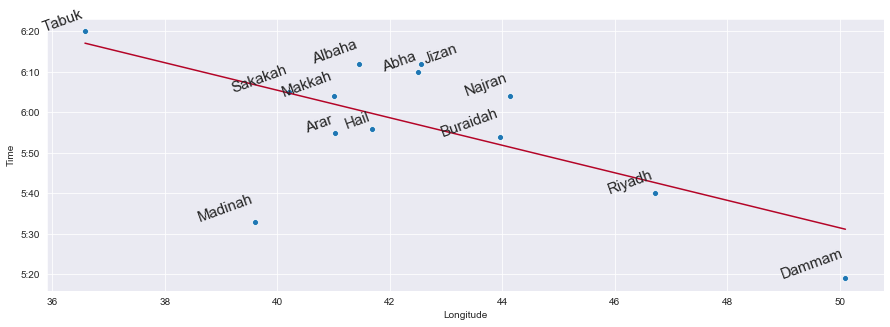

In [8]:
plt.figure(figsize=(15, 5))

plot_data_points(dataset)
reg_x = np.array([min(dataset['Longitude']), max(dataset['Longitude'])])
plt.plot(reg_x, reg_x * model_1_m + model_1_b, color="#b40427")
plt.show()

يمكننا بسهولة النظر إلى الرسم البياني وتحديد النقاط الشاذة. في هذه الحالة توقيت صلاة العيد للمدينة يعتبر نقطة شاذة.

يجب أن نبني نموذج آخر لا يحتوي على النقطة الشاذة لتقليل نسبة الخطأ في تنبؤ النموذج.

تم توضيح أثر النقطة الشاذة في سلسلة سابقة من التحليل الإستكشافي للبيانات.


We can easily look at the plot and determine outliers. In this case, the Eid prayer time for Madinah is an outlier.

We need to build another regression model not containing the outlier to decrease the error rate in the prediction process.

The effect of an outlier on the model has been illustrated in a previous thread about EDA.

In [9]:
# سنبني إطار بيانات آخر لا يحتوي على المدينة
dataset_no_outlier = dataset.drop('Madinah')
# بناء نموذح إنحدار خطي جديد بدون المدينة
model_2 = LinearRegression(fit_intercept=True)
model_2.fit(dataset_no_outlier[['Longitude']], dataset_no_outlier[['Time']])
model_2_m, model_2_b = model_2.coef_[0], model_2.intercept_[0]

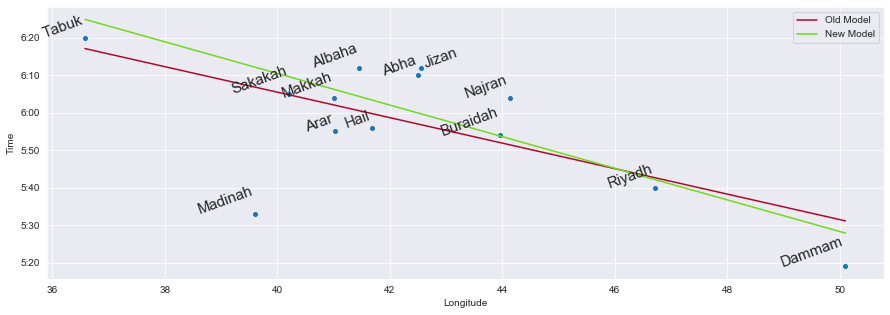

In [10]:
plt.figure(figsize=(15, 5))
plot_data_points(dataset)
reg_x = np.array([min(dataset['Longitude']), max(dataset['Longitude'])])
plt.plot(reg_x, reg_x * model_1_m + model_1_b, color="#b40427", label='Old Model')
plt.plot(reg_x, reg_x * model_2_m + model_2_b, color="#6bdd10", label='New Model')
plt.legend()
plt.show()

بعد إزالة النقطة الشاذة نجد أن نموذج الإنحدار الخطي الجديد (باللون الأخضر) يتوسط نقاط البيانات بشكل أنسب من النموذج القديم (اللون الأحمر) لذلك سنستخدم النموذج الجديد في تحديد وقت صلاة العيد في المدينة.


After removing the outlier, we find that the new regression line (green) runs through the data points better than the old regression line (red). Therefore, we will be using the new regression line to determine the Eid prayer time in Madinah.

هنالك عدة مقاييس لتحديد دقة نموذج الإنحدار الخطي، ولكن سنستخدم المقياس التالي لأنه يلائم احتياجنا لتحديد الفترة الصحيحة لصلاة العيد في المدينة. المقياس هو متوسط القيمة المطلقة للفارق. ويعني ذلك نقيس القيمة المطلقة للفارق بين خط الإنحدار وكل نقطة بيانات ثم نقوم بأخذ المتوسط. بذلك نستطيع تحديد الفترة المتوقعة لصلاة العيد في المدينة.

الصورة التالية ستوضع معنى الفارق بين خط الإنحدار ونقاط البيانات.

There are different metrics to determine the accuracy of a regression model. However, we will be using the following metric since it better suits our needs of finding an accurate interval for Eid prayer in Madinah. The metric is known as Mean Absolute Error. That means we take the absolute value of difference between the regression line and each data point and obtain their mean. This will allow us to determine the expected interval for Eid prayer in Madinah. 

The following plot will demonstrate the meaning of the difference between the regression line and each data point.

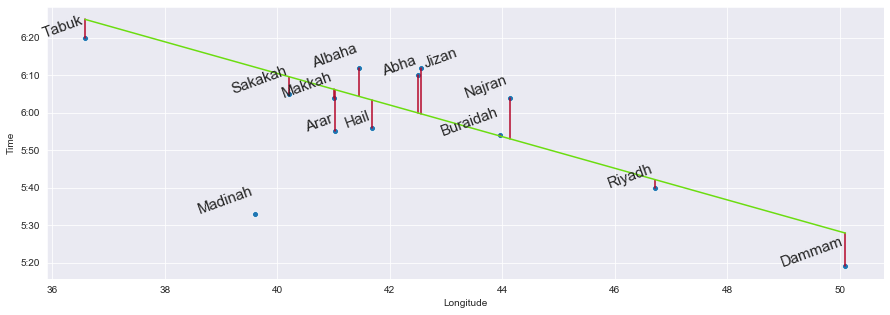

In [11]:
plt.figure(figsize=(15, 5))
plot_data_points(dataset)
plot_error_lines(dataset_no_outlier[['Longitude', 'Time']], model_2)
plt.plot(reg_x, reg_x * model_2_m + model_2_b, color="#6bdd10", label='New Model')

نقوم بحساب متوسط القيمة المطلقة للفروقات كالتالي

We calculate the MAE as follows

In [12]:
MAE_model_1 = abs(model_1.predict(dataset_no_outlier[['Longitude']]) - \
                  dataset_no_outlier[['Time']]).mean()[0].round(2)
MAE_model_2 = abs(model_2.predict(dataset_no_outlier[['Longitude']]) - \
                  dataset_no_outlier[['Time']]).mean()[0].round(2)
print(MAE_model_1, MAE_model_2)

7.08 6.89


من خلال استحدام هذا المقياس نجد أن النموذج الجديد أفضل من النموذج الأول لأن متوسط القيمة المطلقة للفروقات أقل من النموذج الأول

Through utilizing this metric, we find that the new model is better since it has less MAE value than the first model.

سنقوم بتوقع وقت صلاة العيد في المدينة باستخدام النموذج الجديد، ثم نستخدم متوسط القيمة المطلقة للفروقات لإيجاد فترة للوقت

We will predict the Eid prayer time for Madinah using the new model, and use the MAE value to find an interval for the time.

In [13]:
Madinah_Longitude = dataset.loc[['Madinah']][['Longitude']]
predicted_time = model_2.predict(Madinah_Longitude)[0]
predicted_time_low = predicted_time - MAE_model_2
predicted_time_high = predicted_time + MAE_model_2
print(f"Predicted Time is {integer_to_time_str(predicted_time)}")
print(f"Predicted Time is between {integer_to_time_str(predicted_time_low)} and {integer_to_time_str(predicted_time_high)}")

Predicted Time is ['6:12']
Predicted Time is between ['6:05'] and ['6:19']


Text(39.6, [381.03716044], '6:19')

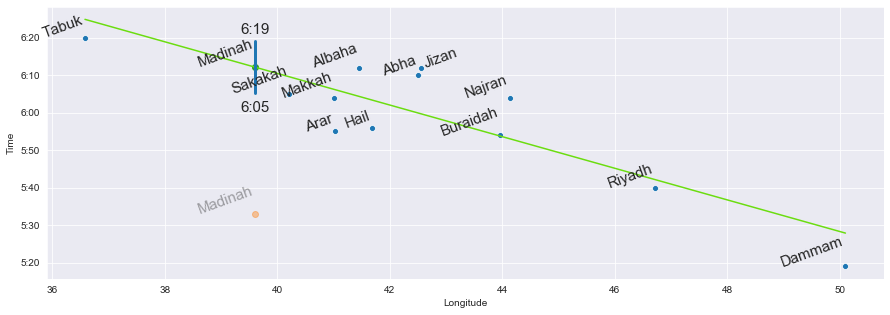

In [14]:
plt.figure(figsize=(15, 5))
plot_data_points(dataset_no_outlier)
plt.plot(reg_x, reg_x * model_2_m + model_2_b, color="#6bdd10", label='New Model')
plt.scatter(Madinah_Longitude, dataset.loc['Madinah'][['Time']][0], alpha=0.4)
plt.text(x=dataset.loc['Madinah'][['Longitude']][0], 
         y=dataset.loc['Madinah'][['Time']][0], s="Madinah", alpha=0.4,
         fontsize=15, horizontalalignment='right', rotation=20)

plt.scatter(Madinah_Longitude, predicted_time)
plt.text(x=dataset.loc['Madinah'][['Longitude']][0], 
         y=predicted_time, s="Madinah",
         fontsize=15, horizontalalignment='right', rotation=20)
plt.plot([dataset.loc['Madinah'][['Longitude']][0], dataset.loc['Madinah'][['Longitude']][0]],
         [predicted_time_low, predicted_time_high], linewidth=3)
plt.text(dataset.loc['Madinah'][['Longitude']][0], predicted_time_low-5, 
         str(integer_to_time_str(predicted_time_low)[0]), fontsize=15,
        horizontalalignment='center')
plt.text(dataset.loc['Madinah'][['Longitude']][0], predicted_time_high+2, 
         str(integer_to_time_str(predicted_time_high)[0]), fontsize=15,
        horizontalalignment='center')

من خلال هذا المثال استطعنا تطبيق مهارات التحليل الإستكشافي للبيانات وتحسين أداء النموذح. كذلك استطعنا تحديد الفترة الزمنية التي نفترض أن تقام فيها صلاة العيد في المدينة ما بين 6:05 وحتى 6:19

Through this example, we were able to apply EDA skills and enhance the model. Also, we were able to determine the time interval which the Eid prayer is expected to perform between 6:05 to 6:19